## Load packages and data

In [1]:
import sys
#!{sys.executable} -m pip install neattext
#!{sys.executable} -m pip install wordcloud
#!{sys.executable} -m pip install nltk
import pandas as pd
import numpy as np
import neattext as nt
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
fake_df=pd.read_csv('../data/Fake.csv')
true_df=pd.read_csv('../data/True.csv')
true_df['class'] = pd.Series(0, index=true_df.index)
fake_df['class'] = pd.Series(1, index=fake_df.index)
df = pd.concat([true_df, fake_df]).reset_index()
del true_df
del fake_df
df.head()

,index,title,text,subject,date,class
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [3]:
df['class'].value_counts()

1    23481
0    21417
Name: class, dtype: int64

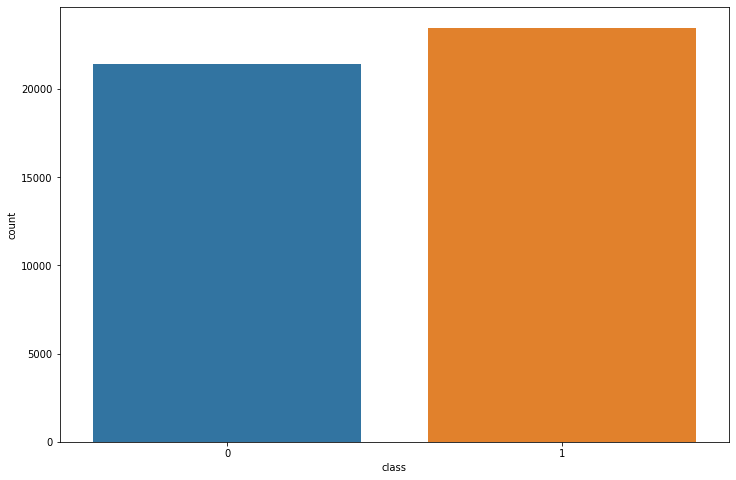

In [4]:
plt.figure(figsize=(12,8))
sns.countplot(x=df['class']);

In [5]:
df['class'].value_counts()[1]/df['class'].count()

0.5229854336496058

In [6]:
df.shape

(44898, 6)

## Data Exploration

First, I check if there are any duplicates of articles and remove them.

In [7]:
df.duplicated('text').sum()
df.drop_duplicates(subset = ['text'], inplace=True)
print(df.shape)

(38646, 6)


In [8]:
df['class'].value_counts()

0    21192
1    17454
Name: class, dtype: int64

In [9]:
# percent of fake articles in the sample
df['class'].value_counts()[1]/df['class'].count()

0.4516379444185685

## Data Preprocessing and Visualization

For preprocessing the data, I use Python packaged called NeatText.  It is a package created to clean unstructured text data and to reduce the noise, such as special characters and stopwords.

In [10]:
import re
def preProcess(t1):
    '''
    This function pre-processes the text, using the neattext package.
    Do not forget to import the neattext and re packages before using this function.
    Arg:
    t1 = text
    Output:
    text
    '''
    t1 = nt.remove_emails(t1)
    t1 = nt.remove_urls(t1)
    t1 = nt.normalize(t1, level='deep')
    t1 = nt.remove_stopwords(t1)
    t1 = nt.remove_html_tags(t1)
    t1 = nt.remove_special_characters(t1)
    t1 = nt.remove_numbers(t1)
    t1 = nt.remove_emojis(t1)
    t1 = nt.fix_contractions(t1)
    t1 = nt.remove_puncts(t1)
    # remove newlines/tabs, etc. 
    t1 = re.sub(r"\t", " ", t1)
    t1 = re.sub(r"\n", " ", t1)
    t1 = re.sub("  ", " ", t1)
    t1 = re.sub("   ", " ", t1)
    return t1


In [11]:
df['preProcessText'] = df['text'].apply(preProcess)

In [12]:
# let's look at a sample of the pre-processed text 
df['preProcessText'][64]

'washington reuters senator lisa murkowski alaska republican decadeslong battle wednesday open arctic wildlife reserve state oil gas drilling democratic senators conservationists vow war begun tax bill passed congress contains language pushed murkowski supported president donald trump hold lease sales millionacre hectare area northern coastal plain arctic national wildlife refuge anwr democrats environmentalists deplore prospect development anwr home polar grizzly bears species birds gwichin natives depend migrating herds porcupine caribou senator maria cantwell democrat said fight drilling fact today beginning said cantwell adding democrats sure trump administration follows environmental laws allowing drilling murkowski said anwr oil provide jobs reduce imports crude help fill transalaska pipeline source oil west coast pipeline operating quarter capacity alaskan production slumped recent years trump expected quickly sign tax bill law said aware fellow republican politicians long tryin

In the next step, I stem the texts, using PorterStemmer.

In [13]:
stemmer = PorterStemmer()
ps = PorterStemmer()
stem = lambda x: ' '.join(list(map(stemmer.stem, x.split())))
df['preProcessTextStem'] = df['preProcessText'].apply(stem)


In [14]:
df['preProcessTextStem'][64]

'washington reuter senat lisa murkowski alaska republican decadeslong battl wednesday open arctic wildlif reserv state oil ga drill democrat senat conservationist vow war begun tax bill pass congress contain languag push murkowski support presid donald trump hold leas sale millionacr hectar area northern coastal plain arctic nation wildlif refug anwr democrat environmentalist deplor prospect develop anwr home polar grizzli bear speci bird gwichin nativ depend migrat herd porcupin carib senat maria cantwel democrat said fight drill fact today begin said cantwel ad democrat sure trump administr follow environment law allow drill murkowski said anwr oil provid job reduc import crude help fill transalaska pipelin sourc oil west coast pipelin oper quarter capac alaskan product slump recent year trump expect quickli sign tax bill law said awar fellow republican politician long tri oil anwr friend oil busi said cant believ anwr theyv tri year trump said start cabinet meet trump said open anwr

## Exploratory Visualization: Word Cloud

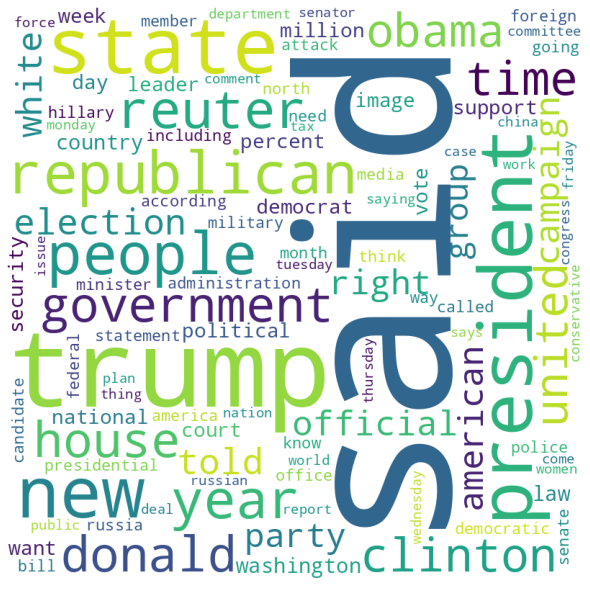

In [15]:
textTxt = ' '.join(df['preProcessText'].values)

wordcloudTxt = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                collocations=False, max_words=100).generate(textTxt)
                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloudTxt)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig("first_wordcloud.png")
plt.show()

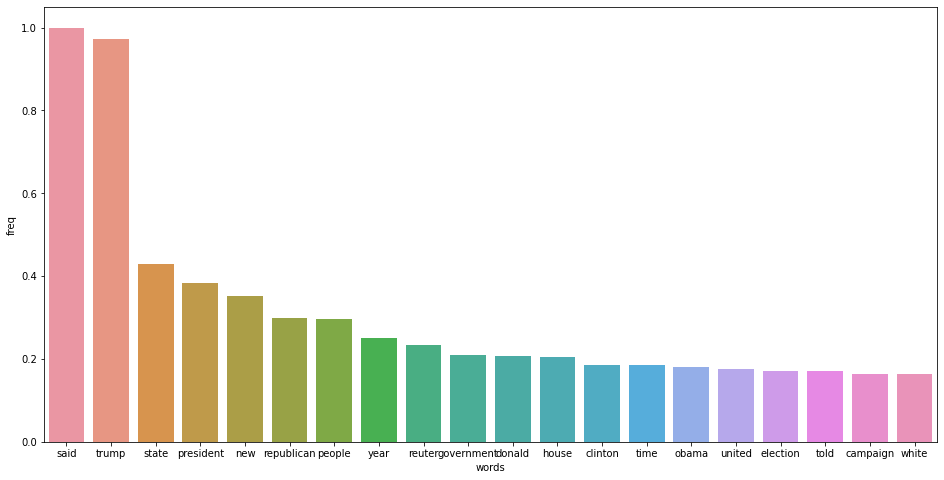

In [16]:
words, freq = list(wordcloudTxt.words_.keys()), list(wordcloudTxt.words_.values())
txtWords = pd.DataFrame(data = list(zip(words[:20], freq[:20])), columns=['words', 'freq'])
plt.figure(figsize=(16,8))
sns.barplot(x=txtWords['words'], y=txtWords['freq'])
plt.savefig("frequencies.png")

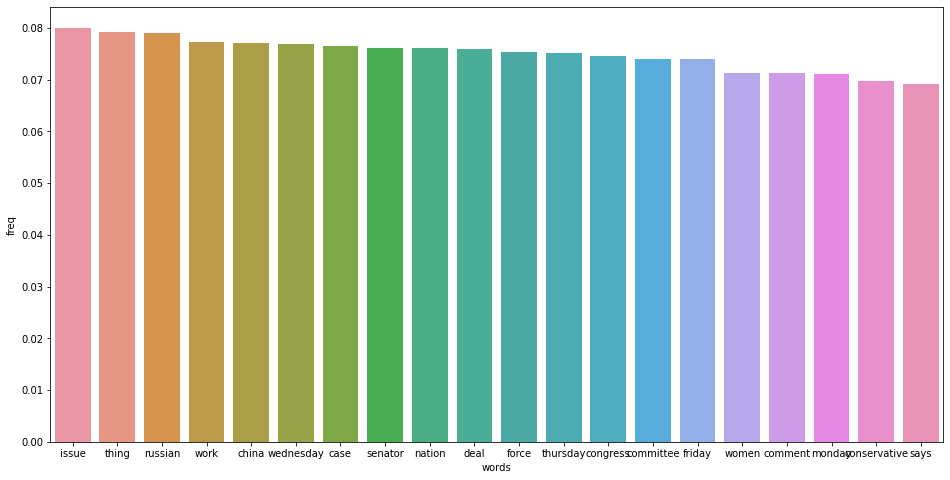

In [17]:
words, freq = list(wordcloudTxt.words_.keys()), list(wordcloudTxt.words_.values())
txtWords = pd.DataFrame(data = list(zip(words[-20:], freq[-20:])), columns=['words', 'freq'])
plt.figure(figsize=(16,8))
sns.barplot(x=txtWords['words'], y=txtWords['freq'])
plt.savefig("least_frequencies.png")

In [18]:
X, Y = df['preProcessTextStem'], df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
del df
del X
del Y
del textTxt
del wordcloudTxt
del words
del freq

In [19]:
X_train.head()

20927    shamlapur bangladeshdhaka reuter myanmar leade...
35445    harden cruz support switch vote hear sick libe...
35122    media ignor fact man reportedli way harm gay a...
26165    age audienc combin devast sexual harass lawsui...
2282     chicagonew york reuter chicago sue trump admin...
Name: preProcessTextStem, dtype: object

## Testing pipelines with Count Vectorizer vs TF-IDF Vectorizer

In [20]:
import xgboost as xgb
pipxgb_cv = Pipeline([('cv', CountVectorizer()), ('xgb', xgb.XGBClassifier(objective='binary:logistic', 
                          base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                          importance_type='gain', interaction_constraints='',
                          learning_rate=0.3, max_delta_step=0, max_depth=6,
                          min_child_weight=1, missing=np.nan, monotone_constraints='()',
                          n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
                          subsample=1, tree_method='exact', validate_parameters=1,
                          verbosity=None, use_label_encoder=False, eval_metric='logloss'))]) 
score_xgb_cv = cross_val_score(estimator=pipxgb_cv, X=X_train, y=y_train, cv=3)
print('Mean Score: ', score_xgb_cv.mean())

Mean Score:  0.9956009571451291


In [21]:
pipxgb_idf = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_df=0.5)), ('xgb', xgb.XGBClassifier(objective='binary:logistic', 
                          base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                          importance_type='gain', interaction_constraints='',
                          learning_rate=0.3, max_delta_step=0, max_depth=6,
                          min_child_weight=1, missing=np.nan, monotone_constraints='()',
                          n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
                          subsample=1, tree_method='exact', validate_parameters=1,
                          verbosity=None, use_label_encoder=False, eval_metric='logloss'))]) 
score_xgb_idf = cross_val_score(estimator=pipxgb_idf, X=X_train, y=y_train, cv=3)
print('Mean Score: ', score_xgb_idf.mean())

Mean Score:  0.9745762554400758


Out of the two vectorizers, count vectorizer performed better than tf-idf one. So for the next step, hyperparameter tuning, only the former was used.

## Hyperparameter tuning

In [22]:
## let's initialize the benchmark model
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                          base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                          importance_type='gain', interaction_constraints='',
                          learning_rate=0.3, max_delta_step=0, max_depth=6,
                          min_child_weight=1, missing=np.nan, monotone_constraints='()',
                          n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
                          subsample=1, tree_method='exact', validate_parameters=1,
                          verbosity=None, use_label_encoder=False, eval_metric='logloss')

In [23]:
## let's transform our X data using Count Vectorizer
vectorizer=CountVectorizer()

new_train=vectorizer.fit_transform(X_train) 
new_test=vectorizer.transform(X_test)
print(new_train.shape)

(30916, 148842)


In [24]:
clf_xgb.fit(new_train,
           y_train,
           verbose=False, 
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(new_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

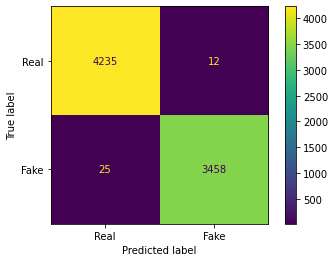

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb, 
                     new_test,
                     y_test,
                     values_format='d',
                     display_labels=['Real', 'Fake'])

In [26]:
y_pred=clf_xgb.predict(new_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
 
print(f"Classification Report : \n\n{classification_report(y_test, y_pred)}")

Accuracy: 99.52%
Classification Report : 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4247
           1       1.00      0.99      0.99      3483

    accuracy                           1.00      7730
   macro avg       1.00      0.99      1.00      7730
weighted avg       1.00      1.00      1.00      7730



## Round 1

In [27]:
clf_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [28]:
from sklearn.model_selection import GridSearchCV
# ROUND 1
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                               seed=42,
                               subsample=0.9,
                               colsample_bytree=0.5),
    param_grid=param_grid,
    scoring ='roc_auc',
    verbose=0,
    n_jobs=16,
    cv=3
)

In [29]:
optimal_params.fit(new_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(new_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

/usr/local/Cellar/jupyterlab/3.0.15_1/libexec/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.0.15_1/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 1.0, 'learning_rate': 0.3, 'reg_lambda': 1.0}


## Round 2

In [30]:
# ROUND 2
param_grid = {
    'gamma': [1, 5, 10]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                               seed=42,
                               subsample=0.9,
                               colsample_bytree=0.5),
    param_grid=param_grid,
    scoring ='roc_auc',
    verbose=0,
    n_jobs=16,
    cv=3
)

In [31]:
optimal_params.fit(new_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(new_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

/usr/local/Cellar/jupyterlab/3.0.15_1/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 1}


## Final Model

The final model after hyperparameter tuning was:

In [32]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                          base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
                          importance_type='gain', interaction_constraints='',
                          learning_rate=0.3, max_delta_step=0, max_depth=6,
                          min_child_weight=1, missing=np.nan, monotone_constraints='()',
                          n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
                          subsample=1, tree_method='exact', validate_parameters=1,
                          verbosity=None, use_label_encoder=False, eval_metric='logloss')

In [33]:
clf_xgb.fit(new_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(new_test, y_test)])

[0]	validation_0-aucpr:0.99463
[1]	validation_0-aucpr:0.99560
[2]	validation_0-aucpr:0.99625
[3]	validation_0-aucpr:0.99652
[4]	validation_0-aucpr:0.99681
[5]	validation_0-aucpr:0.99677
[6]	validation_0-aucpr:0.99706
[7]	validation_0-aucpr:0.99704
[8]	validation_0-aucpr:0.99725
[9]	validation_0-aucpr:0.99720
[10]	validation_0-aucpr:0.99721
[11]	validation_0-aucpr:0.99719
[12]	validation_0-aucpr:0.99767
[13]	validation_0-aucpr:0.99772
[14]	validation_0-aucpr:0.99768
[15]	validation_0-aucpr:0.99783
[16]	validation_0-aucpr:0.99774
[17]	validation_0-aucpr:0.99785
[18]	validation_0-aucpr:0.99863
[19]	validation_0-aucpr:0.99861
[20]	validation_0-aucpr:0.99858
[21]	validation_0-aucpr:0.99876
[22]	validation_0-aucpr:0.99866
[23]	validation_0-aucpr:0.99860
[24]	validation_0-aucpr:0.99876
[25]	validation_0-aucpr:0.99868
[26]	validation_0-aucpr:0.99882
[27]	validation_0-aucpr:0.99877
[28]	validation_0-aucpr:0.99878
[29]	validation_0-aucpr:0.99880
[30]	validation_0-aucpr:0.99878
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

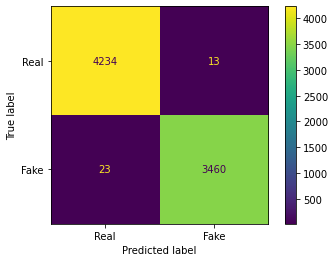

In [34]:
plot_confusion_matrix(clf_xgb, 
                     new_test,
                     y_test,
                     values_format='d',
                     display_labels=['Real', 'Fake'])
plt.savefig("conf_matrix.png")

In [35]:
y_pred=clf_xgb.predict(new_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
 
print(f"Classification Report : \n\n{classification_report(y_test, y_pred)}")

Accuracy: 99.53%
Classification Report : 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4247
           1       1.00      0.99      0.99      3483

    accuracy                           1.00      7730
   macro avg       1.00      1.00      1.00      7730
weighted avg       1.00      1.00      1.00      7730

